<h1>HW 3 Sample Solution</h1>

The task is the following: Using telecom_Churn.xlsx dataset (on Moodle):
1. [40 points] obtain a model estimating the likelihood of customer churn using Logistic
Regression,
2. [40 points] compare several model evaluation metrics and back up your model selection
decision based on the performance of various measures (e.g. ROC AUC, recall etc.),
3. [20 points] interpret the results of the final logistic regression model.

The steps I followed to complete the analysis and comply with the HW requirements are the following:
1. Descriptive analysis
2. Logistic Regression on raw data
3. Logistic Regression on transformed data
4. Scaling and tuning with sklearn
5. Conclusion, selection of the winning model and its interpretation

### Descriptive analysis

Before starting the analysis, we should note that as the assignment requires interpretation of logistic regression coefficient estimates, the analysis would be based on `Logit` from `statsmodels`library. 
The data consists of 3333 observations of 21 variables. The target, **Churn**, is not balanced: there around 85% of customers are staying ("0"), and only 15% are leaving ("1"s.). In my opinion, it is more important to correctly predict the customers who will leave.Therefore, the metrics for choosing the winning model will be recall score and roc-auc on testing set as it is more consistent and also threshold independant metric.

In [41]:
#importing the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from statsmodels.discrete.discrete_model import Logit
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score
import statsmodels.tools as sm
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [2]:
#importing the data and making a dataframe
data=pd.read_excel("Telecom_Churn.xls", sheet_name="churn")

In [3]:
#data overview
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account Length  3333 non-null   int64  
 1   VMail Message   3333 non-null   int64  
 2   Day Mins        3333 non-null   float64
 3   Eve Mins        3333 non-null   float64
 4   Night Mins      3333 non-null   float64
 5   Intl Mins       3333 non-null   float64
 6   CustServ Calls  3333 non-null   int64  
 7   Churn           3333 non-null   int64  
 8   Int'l Plan      3333 non-null   int64  
 9   VMail Plan      3333 non-null   int64  
 10  Day Calls       3333 non-null   int64  
 11  Day Charge      3333 non-null   float64
 12  Eve Calls       3333 non-null   int64  
 13  Eve Charge      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Calls      3333 non-null   int64  
 17  Intl Charge     3333 non-null   f

In [4]:
#have a look at first rows of the dataframe
data.head()

Account Length  VMail Message  Day Mins  Eve Mins  Night Mins  Intl Mins  \
0             128             25     265.1     197.4       244.7       10.0   
1             107             26     161.6     195.5       254.4       13.7   
2             137              0     243.4     121.2       162.6       12.2   
3              84              0     299.4      61.9       196.9        6.6   
4              75              0     166.7     148.3       186.9       10.1   

   CustServ Calls  Churn  Int'l Plan  VMail Plan  ...  Day Charge  Eve Calls  \
0               1      0           0           1  ...       45.07         99   
1               1      0           0           1  ...       27.47        103   
2               0      0           0           0  ...       41.38        110   
3               2      0           1           0  ...       50.90         88   
4               3      0           1           0  ...       28.34        122   

   Eve Charge  Night Calls  Night Charge  Intl Calls  Intl Charge  State  \
0       16.78           91         11.01           3         2.70     KS   
1       16.62          103         11.45           3         3.70     OH   
2       10.30          104          7.32           5         3.29     NJ   
3        5.26           89          8.86           7         1.78     OH   
4       12.61          121          8.41           3         2.73     OK   

  Area Code     Phone  
0       415  382-4657  
1       415  371-7191  
2       415  358-1921  
3       408  375-9999  
4       415  330-6626  

[5 rows x 21 columns]

In [5]:
data.describe()

Account Length  VMail Message     Day Mins     Eve Mins   Night Mins  \
count     3333.000000    3333.000000  3333.000000  3333.000000  3333.000000   
mean       101.064806       8.099010   179.775098   200.980348   200.872037   
std         39.822106      13.688365    54.467389    50.713844    50.573847   
min          1.000000       0.000000     0.000000     0.000000    23.200000   
25%         74.000000       0.000000   143.700000   166.600000   167.000000   
50%        101.000000       0.000000   179.400000   201.400000   201.200000   
75%        127.000000      20.000000   216.400000   235.300000   235.300000   
max        243.000000      51.000000   350.800000   363.700000   395.000000   

         Intl Mins  CustServ Calls        Churn   Int'l Plan   VMail Plan  \
count  3333.000000     3333.000000  3333.000000  3333.000000  3333.000000   
mean     10.237294        1.562856     0.144914     0.096910     0.276628   
std       2.791840        1.315491     0.352067     0.295879     0.447398   
min       0.000000        0.000000     0.000000     0.000000     0.000000   
25%       8.500000        1.000000     0.000000     0.000000     0.000000   
50%      10.300000        1.000000     0.000000     0.000000     0.000000   
75%      12.100000        2.000000     0.000000     0.000000     1.000000   
max      20.000000        9.000000     1.000000     1.000000     1.000000   

         Day Calls   Day Charge    Eve Calls   Eve Charge  Night Calls  \
count  3333.000000  3333.000000  3333.000000  3333.000000  3333.000000   
mean    100.435644    30.562307   100.114311    17.083540   100.107711   
std      20.069084     9.259435    19.922625     4.310668    19.568609   
min       0.000000     0.000000     0.000000     0.000000    33.000000   
25%      87.000000    24.430000    87.000000    14.160000    87.000000   
50%     101.000000    30.500000   100.000000    17.120000   100.000000   
75%     114.000000    36.790000   114.000000    20.000000   113.000000   
max     165.000000    59.640000   170.000000    30.910000   175.000000   

       Night Charge   Intl Calls  Intl Charge    Area Code  
count   3333.000000  3333.000000  3333.000000  3333.000000  
mean       9.039325     4.479448     2.764581   437.182418  
std        2.275873     2.461214     0.753773    42.371290  
min        1.040000     0.000000     0.000000   408.000000  
25%        7.520000     3.000000     2.300000   408.000000  
50%        9.050000     4.000000     2.780000   415.000000  
75%       10.590000     6.000000     3.270000   510.000000  
max       17.770000    20.000000     5.400000   510.000000

In [6]:
#checking number of duplicates, missing values and columns with a single value
print("Duplicates:", data.duplicated().sum())
print("Missing values:", data.isna().sum().sum())
print("Single valued columns:", data.columns[data.nunique()==1])

Duplicates: 0
Missing values: 0
Single valued columns: Index([], dtype='object')


/home/zara-metric/miniconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


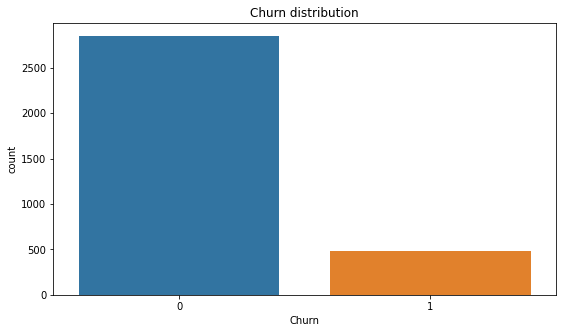

In [7]:
#let's visualise the distribution of churn
plt.figure(figsize=(9,5))
sns.countplot(data.Churn)
plt.title("Churn distribution")
plt.show()

In [8]:
#lets count the benchmark for employee churn
# SO the benchmark accuracy is 85.5% which can be acheived if we predict 0 for all the observations
data.Churn.value_counts(normalize=True).mul(100).rename("Churn percentage")

0    85.508551
1    14.491449
Name: Churn percentage, dtype: float64

In [9]:
#Lets see how many unique values there are in the data
data.nunique()

Account Length     212
VMail Message       46
Day Mins          1667
Eve Mins          1611
Night Mins        1591
Intl Mins          162
CustServ Calls      10
Churn                2
Int'l Plan           2
VMail Plan           2
Day Calls          119
Day Charge        1667
Eve Calls          123
Eve Charge        1440
Night Calls        120
Night Charge       933
Intl Calls          21
Intl Charge        162
State               51
Area Code            3
Phone             3333
dtype: int64

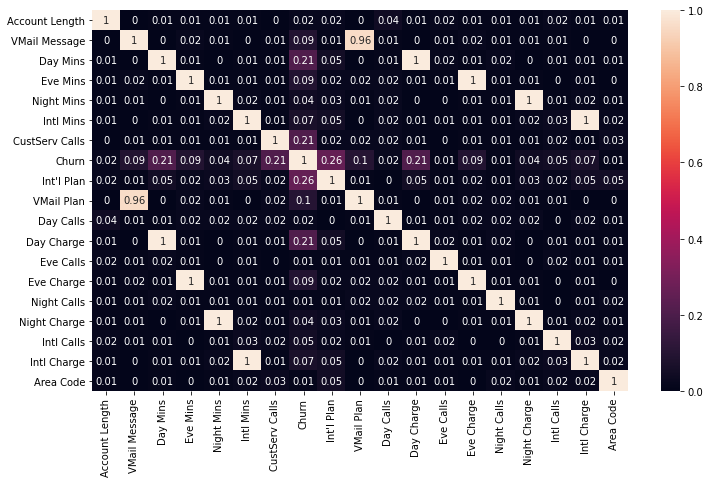

In [10]:
#Let's see the heatmap
plt.figure(figsize=(12,7))
sns.heatmap(data.corr().abs().round(2),annot=True)
plt.show()

As it can be seen, the highest correlation is between VMail Plan and Vmail message,and Mins and Charge pairs. So we will drop for each pair.

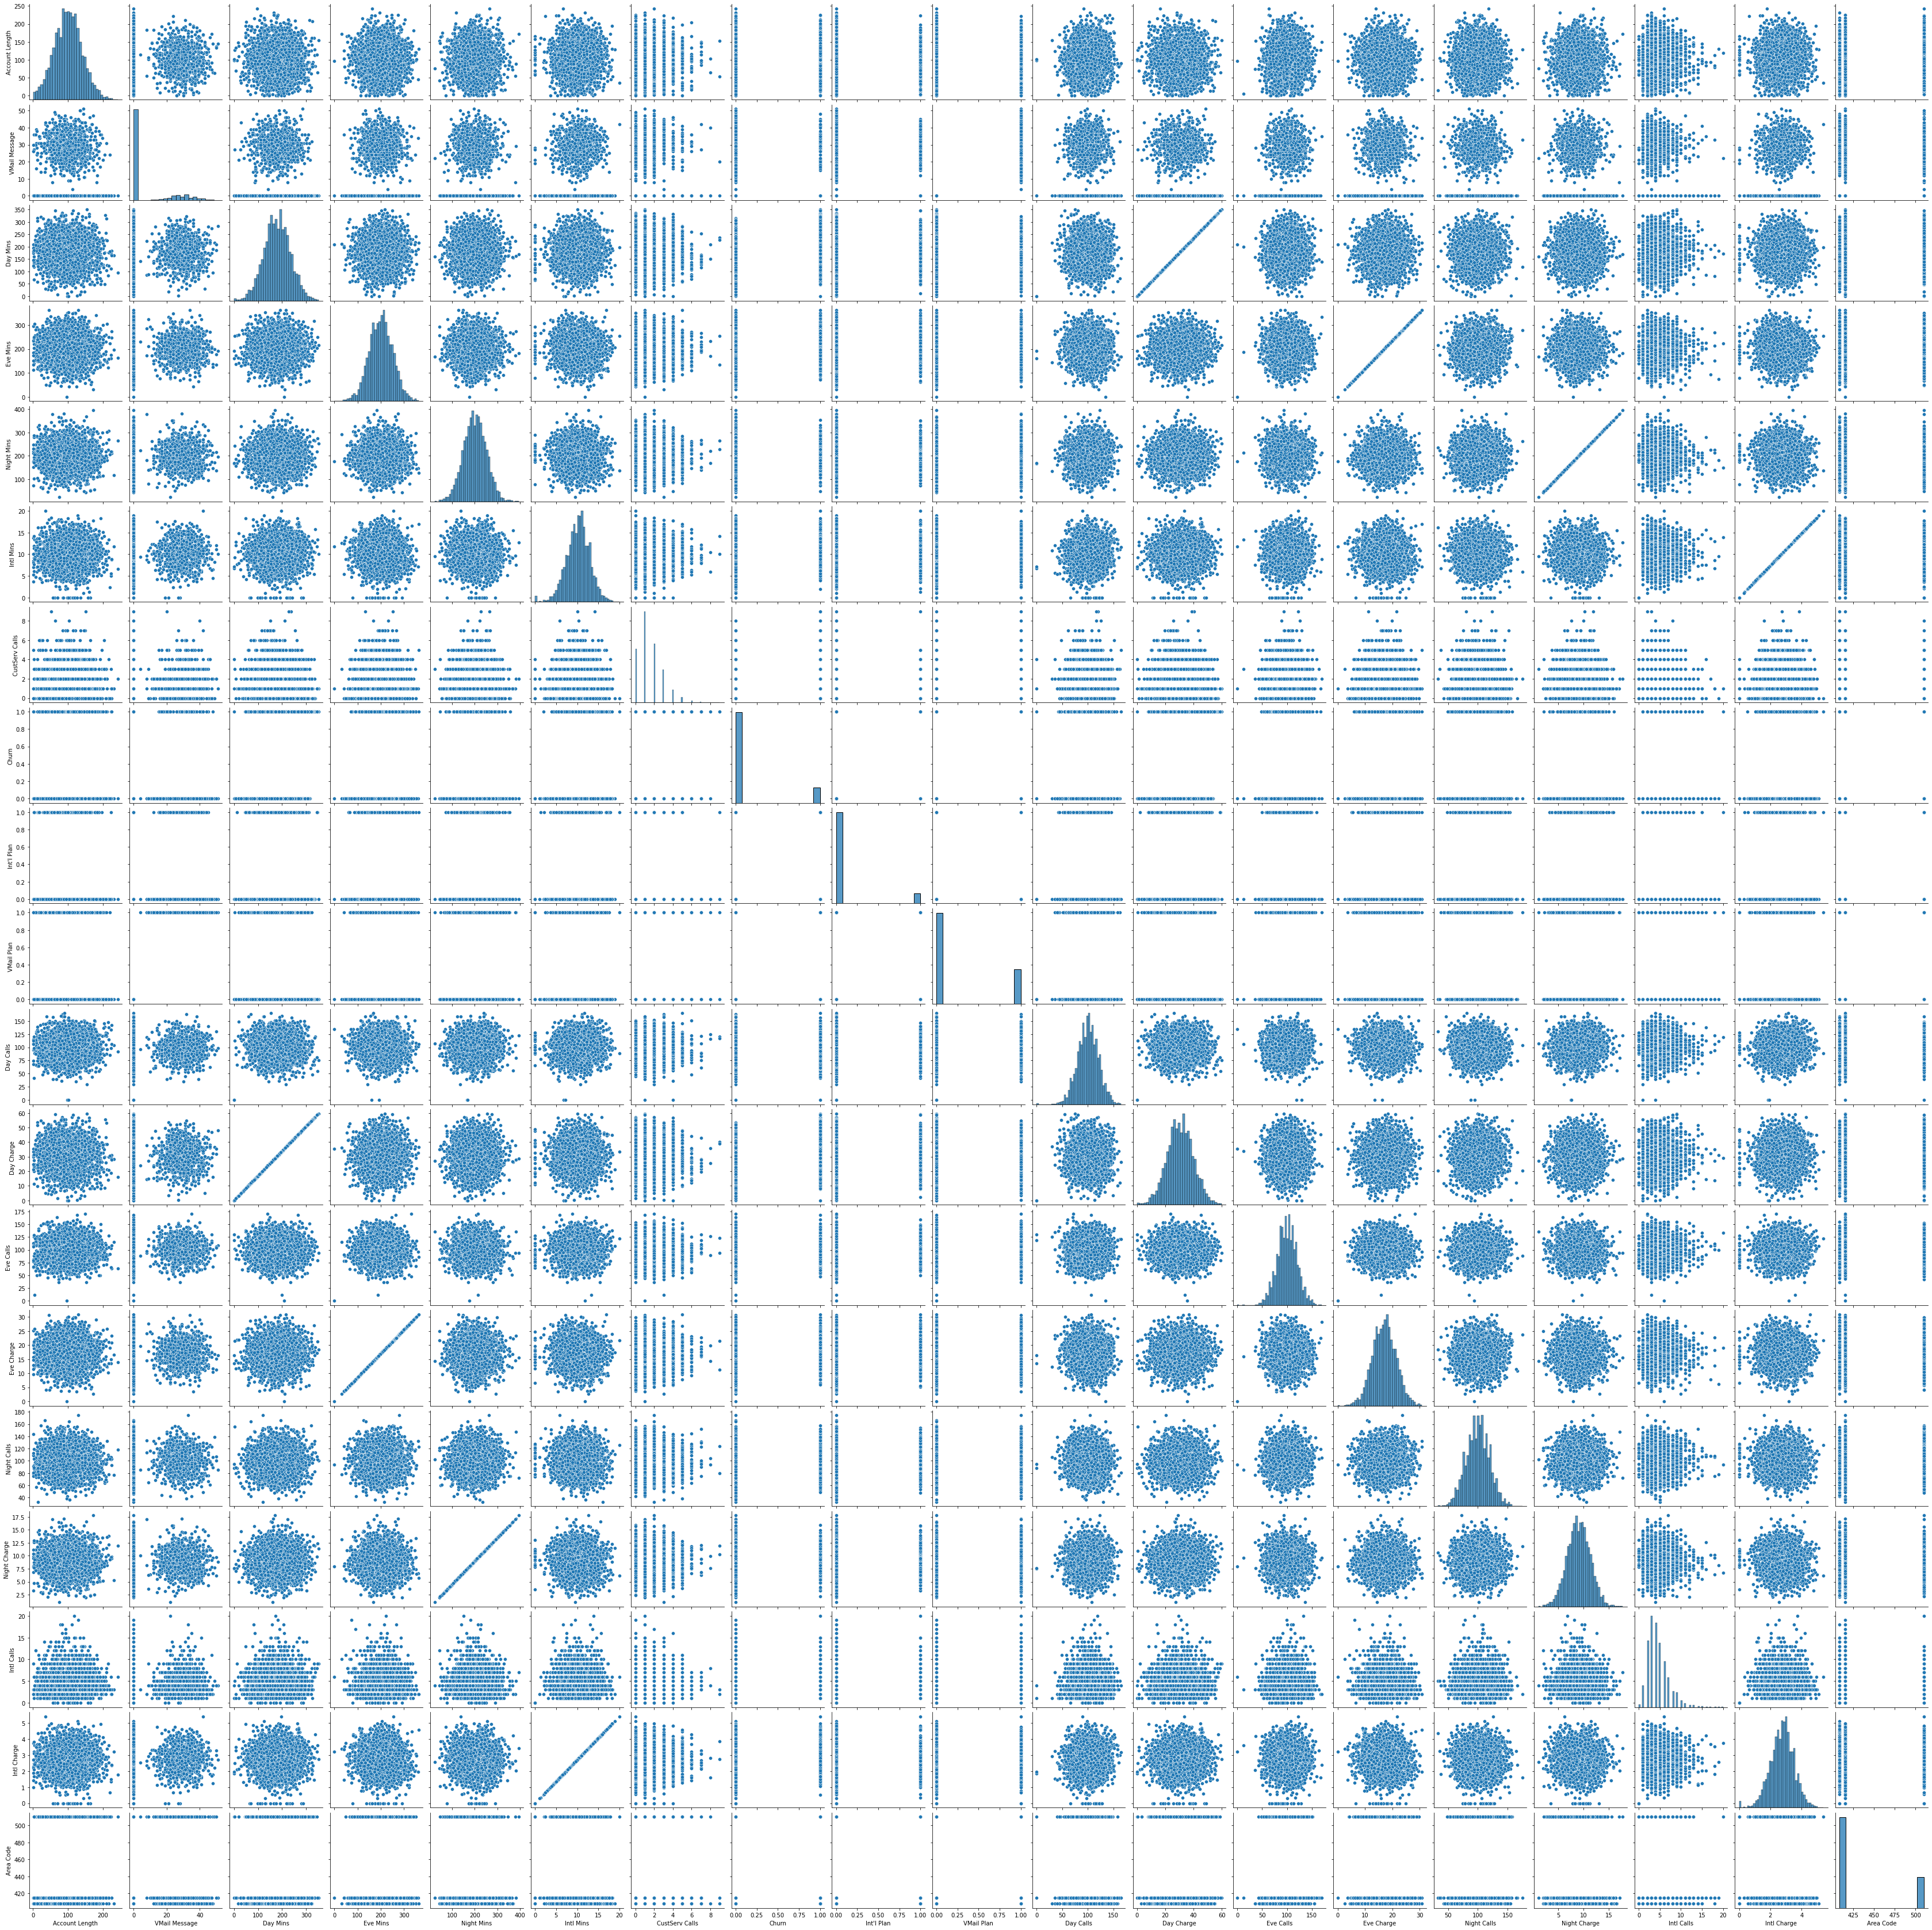

In [23]:
sns.pairplot(data)

We can clearly see linear relationship between Day Charge and Day Mins, Eve Charge and Eve Mins, and Night and Intl Charges and Mins.The same is visible from the correlation matrice.
Area code, Intl Plan and VMail Msg can be converted into categoricals. 

In [11]:
#State and Phone have a lot of values, which cannot be somehow grouped and will result in a lot of dummy columns.
#So we will drop them too.
data.drop(["State","Phone","VMail Plan",'Intl Mins','Night Mins','Eve Mins','Day Mins'], axis=1, inplace=True)

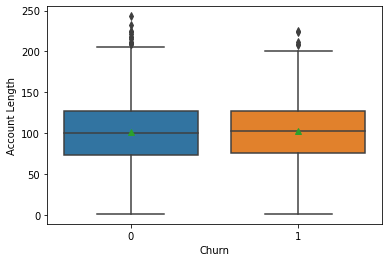

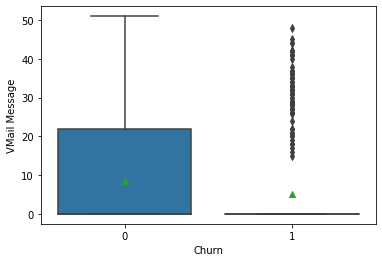

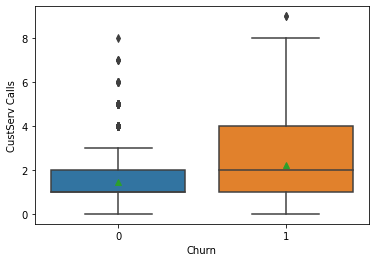

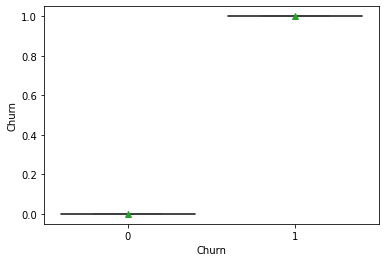

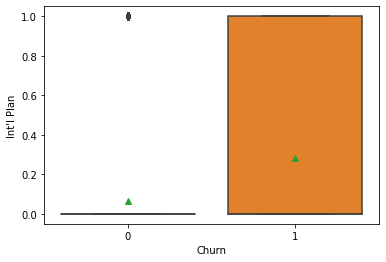

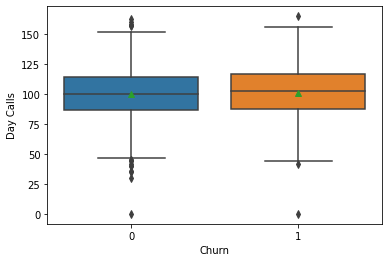

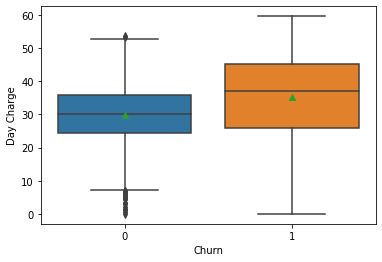

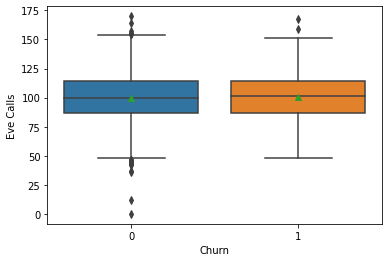

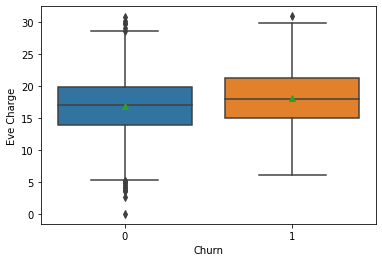

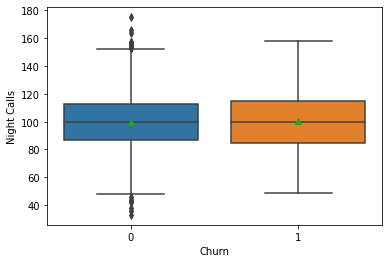

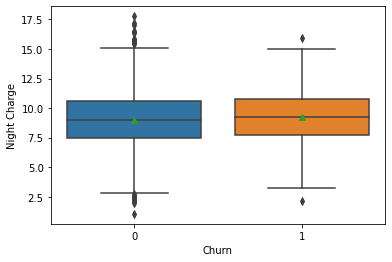

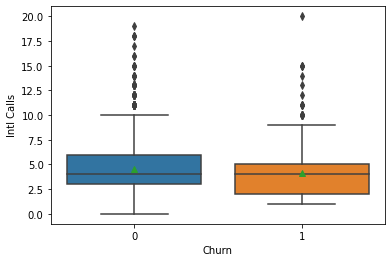

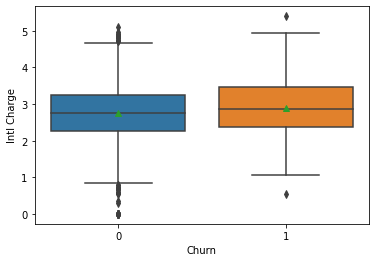

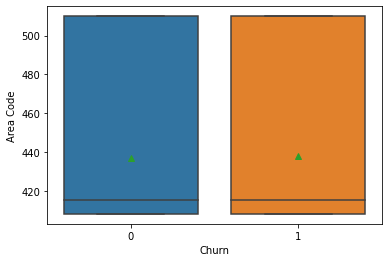

In [12]:
#Let's also see whether mean Churn differs by any of the categorical variables.
#to see that, let's visualize Churn by each categorical variable represented in boxplot.
for i in data.dtypes[data.dtypes!="O"].index.tolist():
    sns.boxplot(data=data,y=i,x="Churn", showmeans=True)
    plt.show()

We can see that there are features such as Account Lenght,  Day Calls, Eve Calls,Area code etc,are not different by number of leaving and staying customers. This will also be taken into account in later transformation.

## Logistic Regression on raw data

In [13]:
#Let's create dummy variables 
data_dum=pd.get_dummies(data,drop_first=True)
#separating X and Y
Y=data_dum["Churn"]
X=data_dum.drop("Churn",axis=1)
#as we are going to use not formula but X and Y data in the logit function, 
#so we need to add the intercept to data (X) manually
X=sm.add_constant(X)
#let's split X and Y data into test and train datasets, test data is 20% of overall data
X0, X1, Y0, Y1 = train_test_split(X, Y, test_size=0.20, random_state=42)

In [14]:
#constructing the logit model
model=Logit(Y0,X0)
#fitting the model
results=model.fit()

Optimization terminated successfully.
         Current function value: 0.324499
         Iterations 7


In [15]:
#predicting for train and test data
Y1_logit=results.predict(sm.add_constant(X1))
Y0_logit=results.predict(X0)

/home/zara-metric/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

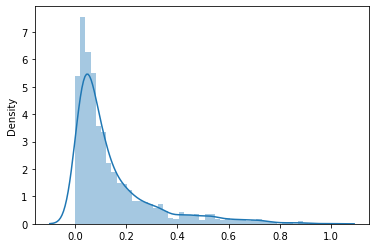

In [16]:
sns.distplot(Y0_logit)

In [17]:
#converting probabilities into labels, from the plot we see that the optimal threshold can be somewhere around 0.1
Y1_logit_1=np.where(Y1_logit>=0.2,1,0)
Y0_logit_1=np.where(Y0_logit>=0.2,1,0)
Y1_logit_2=np.where(Y1_logit>=0.5,1,0)
Y0_logit_2=np.where(Y0_logit>=0.5,1,0)

In [18]:
#calculating classification scores
print("Recall Train on not transformed data:",recall_score(Y0,Y0_logit_1))
print("Recall Test on not transformed data:",recall_score(Y1,Y1_logit_1))
print("Accuracy Train on not transformed data:",accuracy_score(Y0,Y0_logit_1))
print("Accuracy Test on not transformed data:",accuracy_score(Y1,Y1_logit_1))
print("ROC_AUC Train on not transformed data:",roc_auc_score(Y0,results.predict(X0)))
print("ROC_AUC Test on not transformed data:",roc_auc_score(Y1,results.predict(X1)))

Recall Train on not transformed data: 0.6204188481675392
Recall Test on not transformed data: 0.6435643564356436
Accuracy Train on not transformed data: 0.8117029257314329
Accuracy Test on not transformed data: 0.8245877061469266
ROC_AUC Train on not transformed data: 0.8181705650965974
ROC_AUC Test on not transformed data: 0.8221845152713151


In [19]:
#calculating classification scores
print("Recall Train on not transformed data:",recall_score(Y0,Y0_logit_2))
print("Recall Test on not transformed data:",recall_score(Y1,Y1_logit_2))
print("Accuracy Train on not transformed data:",accuracy_score(Y0,Y0_logit_2))
print("Accuracy Test on not transformed data:",accuracy_score(Y1,Y1_logit_2))
print("ROC_AUC Train on not transformed data:",roc_auc_score(Y0,results.predict(X0)))
print("ROC_AUC Test on not transformed data:",roc_auc_score(Y1,results.predict(X1)))

Recall Train on not transformed data: 0.21465968586387435
Recall Test on not transformed data: 0.16831683168316833
Accuracy Train on not transformed data: 0.8630907726931732
Accuracy Test on not transformed data: 0.8545727136431784
ROC_AUC Train on not transformed data: 0.8181705650965974
ROC_AUC Test on not transformed data: 0.8221845152713151


As we can see accuracy and recall being threshold dependent metrics change when we change the treshold, anyway roc_auc does not.We have quite consistent model in terms of general accuracy and roc_auc score, but we clearly have very low results for recall and overfitting. The recall is low when we take as threshold 0.5 but modifing the threshold when classifying can change the picture.
Thus let's try transformations and see whether it will improve our model performance.

### Logistic Regression on transformed data

Let's make some transformations, as discussed above.

In [20]:
data.head()

Account Length  VMail Message  CustServ Calls  Churn  Int'l Plan  \
0             128             25               1      0           0   
1             107             26               1      0           0   
2             137              0               0      0           0   
3              84              0               2      0           1   
4              75              0               3      0           1   

   Day Calls  Day Charge  Eve Calls  Eve Charge  Night Calls  Night Charge  \
0        110       45.07         99       16.78           91         11.01   
1        123       27.47        103       16.62          103         11.45   
2        114       41.38        110       10.30          104          7.32   
3         71       50.90         88        5.26           89          8.86   
4        113       28.34        122       12.61          121          8.41   

   Intl Calls  Intl Charge  Area Code  
0           3         2.70        415  
1           3         3.70        415  
2           5         3.29        415  
3           7         1.78        408  
4           3         2.73        415

In [21]:
#making variables categorical
data["Int'l Plan"]=data["Int'l Plan"].map({0:"0", 1:"1"})
data["VMail Message"]=np.where(data["VMail Message"]==0,"0","other")

In [22]:
#droping variables based on descriptive plots
data.drop(['Account Length','Day Calls','Eve Calls','Night Calls','Night Charge','Intl Charge', 'Area Code'], axis=1, inplace=True)

In [23]:
#creating dummy variables for transformed data
data_tr=pd.get_dummies(data,drop_first=True)
#separating X and Y
Y_tr=data_tr["Churn"]
X_tr=data_tr.drop("Churn",axis=1)
#as we are going to use not formula but X and Y data in the logit function, 
#so we need to add the intercept to data (X) manually
X_tr=sm.add_constant(X_tr)
#splitting the data into train and test sets
X0_tr, X1_tr, Y0_tr, Y1_tr = train_test_split(X_tr, Y_tr, test_size=0.20, random_state=42)

In [24]:
#constructing logit model for transformed data
model_tr=Logit(Y0_tr,X0_tr)
#fitting the model
results_tr=model_tr.fit()

Optimization terminated successfully.
         Current function value: 0.328011
         Iterations 7


In [25]:
#predicting for train and test data
Y1_logit_tr=results_tr.predict(sm.add_constant(X1_tr))
Y0_logit_tr=results_tr.predict(X0_tr)

/home/zara-metric/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

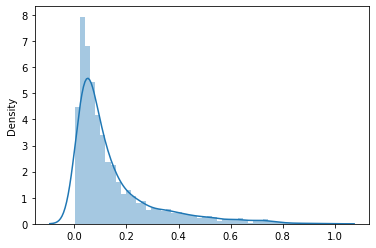

In [26]:
sns.distplot(Y0_logit_tr)

In [27]:
#converting probabilities into labels
Y1_logit_tr=np.where(Y1_logit_tr>=0.2,1,0)
Y0_logit_tr=np.where(Y0_logit_tr>=0.2,1,0)

In [28]:
print("Recall Train on transformed data:",recall_score(Y0_tr,Y0_logit_tr))
print("Recall Test on transformed data:",recall_score(Y1_tr,Y1_logit_tr))
print("Accuracy Train on transformed data:",accuracy_score(Y0_tr,Y0_logit_tr))
print("Accuracy Test on transformed data:",accuracy_score(Y1_tr,Y1_logit_tr))
print("ROC_AUC Train on transformed data:",roc_auc_score(Y0_tr,results_tr.predict(X0_tr)))
print("ROC_AUC Test on transformed data:",roc_auc_score(Y1_tr,results_tr.predict(X1_tr)))

Recall Train on transformed data: 0.612565445026178
Recall Test on transformed data: 0.6435643564356436
Accuracy Train on transformed data: 0.808702175543886
Accuracy Test on transformed data: 0.8215892053973014
ROC_AUC Train on transformed data: 0.8156547711830994
ROC_AUC Test on transformed data: 0.8273624182206207


# Scaling the data and using sklearn

In [33]:
# scale the data 
scaler = StandardScaler()
scaler.fit(X0_tr)
X0_scaled = pd.DataFrame(scaler.transform(X0_tr), columns=X0_tr.columns,index = X0_tr.index)
X1_scaled = pd.DataFrame(scaler.transform(X1_tr), columns=X1_tr.columns,index = X1_tr.index)

In [34]:
logit=LogisticRegression(random_state=42)
logit.fit(X0_scaled,Y0_tr)

LogisticRegression(random_state=42)

In [36]:
Y0_logit_scaled=logit.predict_proba(X0_scaled)[:,1]
Y1_logit_scaled=logit.predict_proba(X1_scaled)[:,1]

/home/zara-metric/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

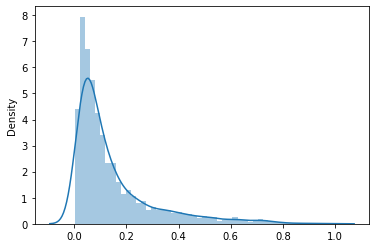

In [37]:
sns.distplot(Y0_logit_scaled)

In [38]:
Y0_logit_class=np.where(Y0_logit_scaled>=0.2,1,0)
Y1_logit_class=np.where(Y1_logit_scaled>=0.2,1,0)

In [39]:
print("Recall Train on transformed data:",recall_score(Y0_tr,Y0_logit_class))
print("Recall Test on transformed data:",recall_score(Y1_tr,Y1_logit_tr))
print("Accuracy Train on transformed data:",accuracy_score(Y0_tr,Y0_logit_class))
print("Accuracy Test on transformed data:",accuracy_score(Y1_tr,Y1_logit_tr))
print("ROC_AUC Train on transformed data:",roc_auc_score(Y0_tr,Y0_logit_scaled))
print("ROC_AUC Test on transformed data:",roc_auc_score(Y1_tr,Y1_logit_scaled))

Recall Train on transformed data: 0.612565445026178
Recall Test on transformed data: 0.6435643564356436
Accuracy Train on transformed data: 0.808702175543886
Accuracy Test on transformed data: 0.8215892053973014
ROC_AUC Train on transformed data: 0.8156994709382822
ROC_AUC Test on transformed data: 0.8273799111359901


In [42]:
logit_1=LogisticRegression(random_state=42)

param_logit = {'class_weight':[None, 'balanced'], 'C':np.linspace(1,10,20),
              'solver':['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}

gs_logit=GridSearchCV(estimator=logit_1, param_grid=param_logit,
                      scoring="roc_auc", cv=5, verbose=1, n_jobs=-1).fit(X0_scaled,Y0_tr)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 664 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    6.4s finished


In [43]:
best_params = gs_logit.best_params_
print(best_params)

{'C': 1.0, 'class_weight': 'balanced', 'solver': 'sag'}


In [44]:
logit_grid=LogisticRegression(random_state=42, C=best_params['C'], class_weight=best_params['class_weight'],
                              solver=best_params['solver']).fit(X0_scaled,Y0)

Y0_logit_grid=logit_grid.predict_proba(X0_scaled)[:,1]
Y1_logit_grid=logit_grid.predict_proba(X1_scaled)[:,1]

/home/zara-metric/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

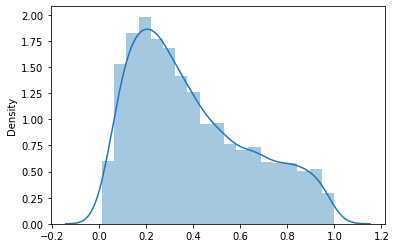

In [49]:
sns.distplot(Y0_logit_grid)

In [52]:
Y0_logit_class=np.where(Y0_logit_grid>=0.4,1,0)
Y1_logit_class=np.where(Y0_logit_grid>=0.4,1,0)

In [53]:
print("Recall Train on transformed data:",recall_score(Y0_tr,Y0_logit_class))
print("Recall Test on transformed data:",recall_score(Y1_tr,Y1_logit_tr))
print("Accuracy Train on transformed data:",accuracy_score(Y0_tr,Y0_logit_class))
print("Accuracy Test on transformed data:",accuracy_score(Y1_tr,Y1_logit_tr))
print("ROC_AUC Train on transformed data:",roc_auc_score(Y0_tr,Y0_logit_grid))
print("ROC_AUC Test on transformed data:",roc_auc_score(Y1_tr,Y1_logit_grid))

Recall Train on transformed data: 0.8429319371727748
Recall Test on transformed data: 0.6435643564356436
Accuracy Train on transformed data: 0.6916729182295573
Accuracy Test on transformed data: 0.8215892053973014
ROC_AUC Train on transformed data: 0.819228459302592
ROC_AUC Test on transformed data: 0.8281670923276073


## Conclusion, selection of the winning model and its interpretation

As already noted, the winning model selection criteria for me is higher recall and roc_auc on testing set. So as none of the model has a significant difference in terms of metrics, it is also important to compare models in terms of simplicity. So we will choose as winner model the transformed not scaled model as it is the most simple yet the same performance in terms of recall and roc-auc on the test set.

In [54]:
results_tr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:                 2666
Model:                          Logit   Df Residuals:                     2659
Method:                           MLE   Df Model:                            6
Date:                Thu, 26 Nov 2020   Pseudo R-squ.:                  0.2017
Time:                        10:53:40   Log-Likelihood:                -874.48
converged:                       True   LL-Null:                       -1095.4
Covariance Type:            nonrobust   LLR p-value:                 2.750e-92
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -5.8015      0.403    -14.396      0.000      -6.591      -5.012
CustServ Calls          0.4992      0.042     11.781      0.000       0.416       0.582
Day Charge              0.0691      0.007      9.910      0.000       0.055       0.083
Eve Charge              0.0661      0.015      4.494      0.000       0.037       0.095
Intl Calls             -0.1000      0.029     -3.508      0.000      -0.156      -0.044
VMail Message_other    -0.9098      0.162     -5.601      0.000      -1.228      -0.591
Int'l Plan_1            2.0918      0.160     13.051      0.000       1.778       2.406
=======================================================================================
"""

The interpretation will be for significant variables only:
- <b> For a one-unit increase in CustServ Calls we expect on average a 0.4992 increase in the log-odds of churn, holding all other independent variables constant.</b>
- <b> For a one-unit increase in Eve Charge we expect on average a 0.0661 increase in the log-odds of churn, holding all other independent variables constant.</b>
- <b> For customers having VMail Message other, we expect on average a 0.9098 decrease in the log-odds of churn compared to the customers with 0 VMail Messages.</b>
- <b> For customers having Int'l Plan 1, we expect on average a 2.0918 increase in the log-odds of churn compared to the customers with Int'l Plan 0.</b>

In [55]:
results_tr.get_margeff().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
        Logit Marginal Effects       
=====================================
Dep. Variable:                  Churn
Method:                          dydx
At:                           overall
=======================================================================================
                         dy/dx    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
CustServ Calls          0.0491      0.004     12.495      0.000       0.041       0.057
Day Charge              0.0068      0.001     10.267      0.000       0.006       0.008
Eve Charge              0.0065      0.001      4.525      0.000       0.004       0.009
Intl Calls             -0.0098      0.003     -3.519      0.000      -0.015      -0.004
VMail Message_other    -0.0895      0.016     -5.650      0.000      -0.121      -0.058
Int'l Plan_1            0.2058      0.014     14.424      0.000       0.178       0.234
=======================================================================================
"""

The interpretation will be for significant variables only:
- <b> An Incremental increase in CustServ Calls will increase the probability of churn on average by 4.91% when other factors are held constant.</b>
- <b> An Incremental increase in Eve Charge will increase the probability of churn on average by ‭0.68% when other factors are held constant.</b>
- <b> Customers having 'other' VMail Message , have on average 8.9% lower probability of churn compared to customers with '0' VMail Messages.</b>
- <b> Customers having Int'l Plan 1, have on average 20.58% higher probability of churn compared to the customers with Int'l Plan 0.</b>